# Predicting Goals Scored

# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import log_loss


from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import ensemble, metrics, model_selection as ms, preprocessing, tree

from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.set_option('display.max_columns', 50)

import datetime


from pathlib import Path
import os
from os import listdir
from os.path import isfile, join

## Read in data

In [2]:
results = pd.read_csv(r"C:\\Users\Byron\Documents\Football Predictions\PremierLeaguePredictions\data\ff_us_1419.csv").drop("Unnamed: 0",axis=1)
results.head()

,season,gameweek,matchid,fixture,matchdate,f_Team,f_HmGame,f_Possession,f_Touches - Final Third,f_Touches - Penalty Area,f_Passes - Final Third - Successful,f_Chances Created,f_Goals,f_Goals From Penalties,f_Goal Attempts,f_Shots - Inside Box,f_Big Chances Total,f_Shots On Target,f_Goal Attempts In Box Conceded,f_Shots Conceded,f_Shots On Target Conceded,f_Big Chances Conceded,f_xG Open Play,f_xG Expected Goals,f_xA Expected Assists,f_Goals Conceded,f_xG Conceded,f_Touches - Final Third Conceded,f_Touches - Penalty Area Conceded,f_Passes - Final Third - Successful Conceded,f_xG Open Play Conceded,f_US xG,f_US xG Conceded,f_Points,f_Chances Conceded,gw_no,f_Touches - Final Third log,f_xA Expected Assists Conceded
0,2014,Gameweek 1,/matches/755307/,Manchester United vs Swansea City,2014-08-16 12:45:00,Swansea City,0,40.2,70,6,28,5,2,0,5,1,0,4,8,14,5,1,0.0,0.0,0.0,1,0.0,217,20,91,0.0,0.278076,1.166350,3,11,1,4.248495,NaN
1,2014,Gameweek 1,/matches/755307/,Manchester United vs Swansea City,2014-08-16 12:45:00,Manchester United,1,59.8,217,20,91,11,1,0,14,8,1,5,1,5,4,0,0.0,0.0,0.0,2,0.0,70,6,28,0.0,1.166350,0.278076,0,5,1,5.379897,NaN
2,2014,Gameweek 1,/matches/755305/,Leicester City vs Everton,2014-08-16 15:00:00,Everton,0,64.1,183,30,100,6,2,0,13,8,0,3,7,11,3,3,0.0,0.0,0.0,2,0.0,112,13,40,0.0,0.613273,1.278300,1,6,1,5.209486,NaN
3,2014,Gameweek 1,/matches/755305/,Leicester City vs Everton,2014-08-16 15:00:00,Leicester City,1,35.9,112,13,40,6,2,0,11,7,3,3,8,13,3,0,0.0,0.0,0.0,2,0.0,183,30,100,0.0,1.278300,0.613273,1,6,1,4.718499,NaN
4,2014,Gameweek 1,/matches/755309/,Queens Park Rangers vs Hull City,2014-08-16 15:00:00,Hull City,0,49.6,127,19,44,9,1,0,11,8,1,4,12,19,5,2,0.0,0.0,0.0,0,0.0,153,33,50,0.0,1.117570,1.900670,3,14,1,4.844187,NaN


In [3]:
results.groupby("season").agg(
    matches =("fixture","nunique"),
    teams =("f_Team","nunique")
)

,matches,teams
season,,
2014,380,20
2015,380,20
2016,380,20
2017,380,20
2018,380,20
2019,278,20


In [4]:
features = [i for i in results.columns if i.startswith("f_") and i !="f_Team"]
def_features = [i for i in features if "Conceded" in i]
att_features = [i for i in features if i not in def_features]
print(att_features)
print()
print(def_features)


['f_HmGame', 'f_Possession', 'f_Touches - Final Third', 'f_Touches - Penalty Area', 'f_Passes - Final Third - Successful', 'f_Chances Created', 'f_Goals', 'f_Goals From Penalties', 'f_Goal Attempts', 'f_Shots - Inside Box', 'f_Big Chances Total', 'f_Shots On Target', 'f_xG Open Play', 'f_xG Expected Goals', 'f_xA Expected Assists', 'f_US xG', 'f_Points', 'f_Touches - Final Third log']

['f_Goal Attempts In Box Conceded', 'f_Shots Conceded', 'f_Shots On Target Conceded', 'f_Big Chances Conceded', 'f_Goals Conceded', 'f_xG Conceded', 'f_Touches - Final Third Conceded', 'f_Touches - Penalty Area Conceded', 'f_Passes - Final Third - Successful Conceded', 'f_xG Open Play Conceded', 'f_US xG Conceded', 'f_Chances Conceded', 'f_xA Expected Assists Conceded']


## Feature analysis

In [5]:
df_null = results[features].isnull().sum()/results[features].count()
df_null

f_HmGame                                        0.000000
f_Possession                                    0.000000
f_Touches - Final Third                         0.000000
f_Touches - Penalty Area                        0.000000
f_Passes - Final Third - Successful             0.000000
f_Chances Created                               0.000000
f_Goals                                         0.000000
f_Goals From Penalties                          0.000000
f_Goal Attempts                                 0.000000
f_Shots - Inside Box                            0.000000
f_Big Chances Total                             0.000000
f_Shots On Target                               0.000000
f_Goal Attempts In Box Conceded                 0.000000
f_Shots Conceded                                0.000000
f_Shots On Target Conceded                      0.000000
f_Big Chances Conceded                          0.000000
f_xG Open Play                                  0.000000
f_xG Expected Goals            

In [6]:
##handling nulls
df_null = results[features].isnull().sum()/results[features].count()
df_null = df_null[df_null>0]
null_vars = df_null.index.tolist()
print(null_vars)

results = results.drop(null_vars,axis=1)

['f_xA Expected Assists Conceded']


In [7]:
features = [i for i in results.columns if i.startswith("f_") and i !="f_Team"]
def_features = [i for i in features if "Conceded" in i]
att_features = [i for i in features if i not in def_features]
print(att_features)
print()
print(def_features)


['f_HmGame', 'f_Possession', 'f_Touches - Final Third', 'f_Touches - Penalty Area', 'f_Passes - Final Third - Successful', 'f_Chances Created', 'f_Goals', 'f_Goals From Penalties', 'f_Goal Attempts', 'f_Shots - Inside Box', 'f_Big Chances Total', 'f_Shots On Target', 'f_xG Open Play', 'f_xG Expected Goals', 'f_xA Expected Assists', 'f_US xG', 'f_Points', 'f_Touches - Final Third log']

['f_Goal Attempts In Box Conceded', 'f_Shots Conceded', 'f_Shots On Target Conceded', 'f_Big Chances Conceded', 'f_Goals Conceded', 'f_xG Conceded', 'f_Touches - Final Third Conceded', 'f_Touches - Penalty Area Conceded', 'f_Passes - Final Third - Successful Conceded', 'f_xG Open Play Conceded', 'f_US xG Conceded', 'f_Chances Conceded']


### Correlation with Goals For and Against in a match
This looks at individual games and see which match statistics correlate with Goals scored and conceded.


In [8]:
corr_g = results[features].corr()[["f_Goals"]]
corr_gc = results[features].corr()[["f_Goals Conceded"]]
corr_goals = pd.concat([corr_g,corr_gc],axis = 1)
corr_goals
#sns.heatmap(corr_goals,cmap = "coolwarm")

,f_Goals,f_Goals Conceded
f_HmGame,0.137199,-0.137199
f_Possession,0.183362,-0.183358
f_Touches - Final Third,0.179731,-0.170430
f_Touches - Penalty Area,0.310281,-0.177124
f_Passes - Final Third - Successful,0.218825,-0.179779
f_Chances Created,0.325138,-0.186653
f_Goals,1.000000,-0.129303
f_Goals From Penalties,0.242988,-0.019435
f_Goal Attempts,0.330372,-0.173305
f_Shots - Inside Box,0.394843,-0.170827


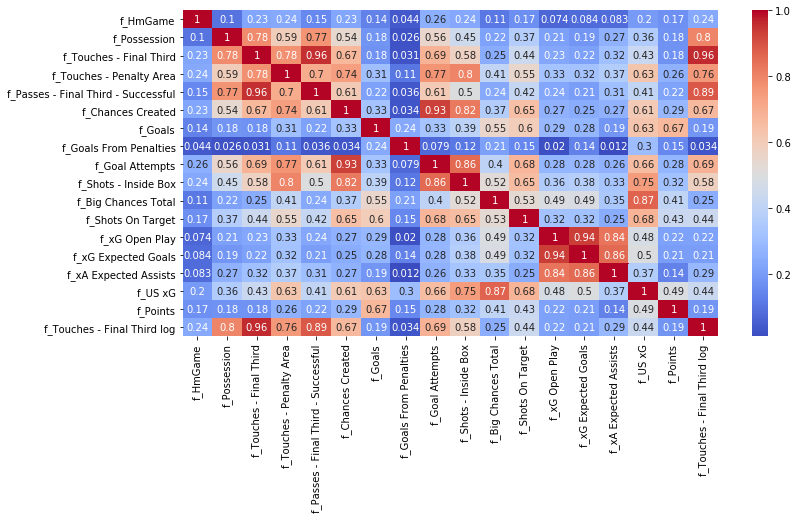

In [9]:
plt.figure(figsize=(12,6))
sns.heatmap(results[att_features].corr(),cmap="coolwarm",annot=True)

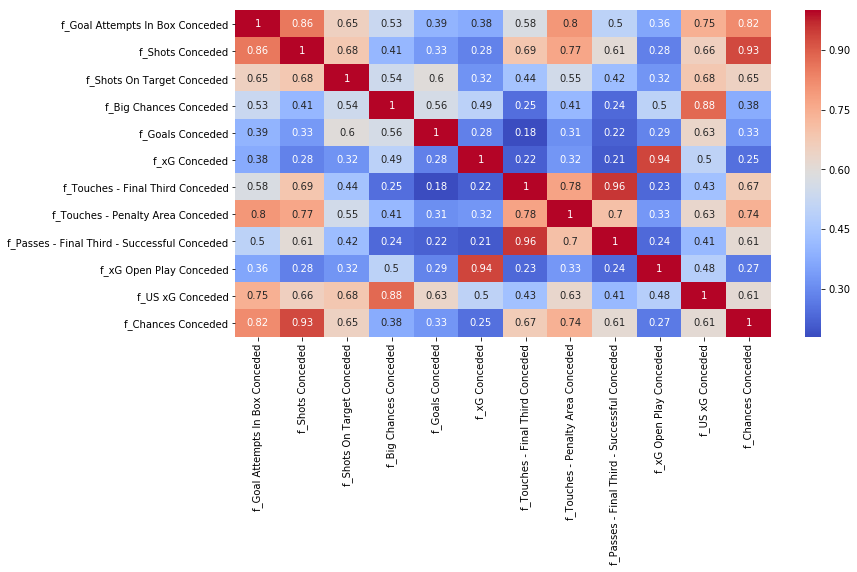

In [10]:
plt.figure(figsize=(12,6))
sns.heatmap(results[def_features].corr(),cmap="coolwarm",annot=True)

#### Summary
Expected Goals, Shots on target, followed Big Chances have the highest correlation with Goals Scored in a game. <br>


## Rolling Average Feature Creation

In order to predict how many goals a team will score or concdede in any given fixture we want to look at the match statistics in their previous games to understand their likelihood to score or concede. <br>

There are a few factors go into this <br>
- Which statistics are most relevant
- How far back should we look to get the statistics for what a team is going to do in their next match
- Can we weight more recent fixtures differently to games that happened a longer time ago?

We will start with using an exponential moving average function, which will create a weighted average of each feature over a specific time period. We can specificy whether or not we want that window to be 2 games or 50 games. However we will be weighting the more recent matches more heavily to take into account changes in form. <br>

Later on we can try and compare it to simple moving average

**######**

**separating out seasons for training, test and validation**

In [11]:
training = results[results["season"].isin([2014,2015,2016,2017])]
test = results[results["season"]==2018]
holdout = results[results["season"]==2019]

In [12]:
#exponentially weighted averages - however this one won't reset after each season
def ema_no_reset(stats, span,feature_cols):
    '''
    Calculates an exponential moving average for each team for the time span required.
    Does not reset after each season
    stats: Dataframe containing Team statistics
    span: Window for which we want to calculate moving average
    feature_cols: list of columns for which we want to create a moving average
    '''
    ema_features = stats[['matchid', 'f_Team', 'gameweek','season','f_HmGame','fixture', 'matchdate','gw_no']].copy()
    for feature_name in set(feature_cols):
        #print(feature_name)
        feature_ema = (stats.groupby(['f_Team'])[feature_name]  # Calculate the EMA
                       .transform(lambda row: row.ewm(span=span, min_periods=2)
                                  .mean()
                                  .shift(1)
                                 ))
        ema_features[feature_name] = feature_ema
    #create some ratios
    ema_features['f_netxg'] = ema_features['f_US xG']-ema_features['f_US xG Conceded']
    ema_features['f_xGRatio'] = ema_features['f_US xG']/(ema_features['f_US xG']+ema_features['f_US xG Conceded'])
    ema_features['f_ShotsRatio'] = ema_features['f_Goal Attempts']/(ema_features['f_Goal Attempts']+ema_features['f_Shots Conceded'])
    ema_features['f_ShOnTargetRatio'] = ema_features['f_Shots On Target']/(ema_features['f_Goal Attempts'])
    return ema_features

In [13]:
def moving_average_no_reset(stats,span,feature_cols):
    '''
    Calculates an standard moving average for each team for the time span required.
    Does not reset after each season
    stats: Dataframe containing Team statistics
    span: Window for which we want to calculate moving average
    feature_cols: list of columns for which we want to create a moving average
    '''
    ema_features = stats[['matchid', 'f_Team', 'gameweek','season','f_HmGame','fixture', 'matchdate','gw_no']].copy()
    for feature_name in set(feature_cols):
        #print(feature_name)
        feature_ema = (stats.groupby(['f_Team'])[feature_name]  # Calculate the EMA
                       .transform(lambda row: row.rolling(window=span, min_periods=2)
                                  .mean()
                                  .shift(1)
                                 ))
        ema_features[feature_name] = feature_ema
    #create some ratios
    ema_features['f_netxg'] = ema_features['f_US xG']-ema_features['f_US xG Conceded']
    ema_features['f_xGRatio'] = ema_features['f_US xG']/(ema_features['f_US xG']+ema_features['f_US xG Conceded'])
    ema_features['f_ShotsRatio'] = ema_features['f_Goal Attempts']/(ema_features['f_Goal Attempts']+ema_features['f_Shots Conceded'])
    ema_features['f_ShOnTargetRatio'] = ema_features['f_Shots On Target']/(ema_features['f_Goal Attempts'])
    return ema_features

In [14]:
# Rolling Average - Resets after each season. Careful around the use of shift, as to whether 
# this is used for predictions or analysis
def rolling_m_gw(stats, span):
    rolling_features = stats[['season','f_HmGame','f_Team','gw_no']].copy()
    for feature_name in gw_av_features:
        #print(feature_name)
        feature_rolling = (stats.groupby(['season','f_HmGame','f_Team'])[feature_name]  # Calculate the EMA
                            .transform(lambda row: row.rolling(window=span, min_periods=2)
                                  .mean()
                                  #.shift(1)
                                 ))
        rolling_features[feature_name] = feature_rolling
    return rolling_features

# Regression to Predict Goals Scored

Our aim here is to try and predict the number of goals scored in the next game for any given team. <br>
One of the challenges is to understand what the length of fixture history gives us the best results.

We will start with linear regression and plot error metric over history used to see what history gives us the best results

In [15]:
calculated_features = ["f_netxg","f_xGRatio","f_ShotsRatio","f_ShOnTargetRatio"]
# att_features = att_features + calculated_features
# def_features = def_features + calculated_features
# print(att_features)
# print()
# print(def_features)

In [16]:
target_goals = results[['f_Team', 'matchid','f_HmGame','f_Goals', 'f_Goals Conceded',"f_US xG", "f_US xG Conceded"]]    
target_goals.columns = ['f_Team', 'matchid','f_HmGameFut','t_Goals', 't_Goals Conceded',"t_US xG", "t_US xG Conceded"]
target_goals.head()

,f_Team,matchid,f_HmGameFut,t_Goals,t_Goals Conceded,t_US xG,t_US xG Conceded
0,Swansea City,/matches/755307/,0,2,1,0.278076,1.166350
1,Manchester United,/matches/755307/,1,1,2,1.166350,0.278076
2,Everton,/matches/755305/,0,2,2,0.613273,1.278300
3,Leicester City,/matches/755305/,1,2,2,1.278300,0.613273
4,Hull City,/matches/755309/,0,1,0,1.117570,1.900670


In [17]:
def optimise_alpha(df, features,target, mod):
    """
    Function to get the cross validation scores of the target goals variable you're predicting
    df: dataframe containing features and target variable
    features: features to be used in the model
    target: Name of the target variable in your model dataset
    model: type of model to be run
    
    """
    df = df.dropna()
    X = df[features]
    y = df[target]
    y = y.apply(lambda x: float(x))
    model = mod
    kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    ave_cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold).mean()
    return ave_cv_score

## Best Span for Linear Regression

In [18]:
target_goals["t_Goals"].value_counts()

1    1423
0    1227
2     989
3     461
4     176
5      57
6      18
7       2
8       2
9       1
Name: t_Goals, dtype: int64

The code below will go from 2 games of history to 38 games of history with an interval of 2 and plot the error metric on a curve.

The lowest span occured at 36
The lowest error was -1.294520815670107


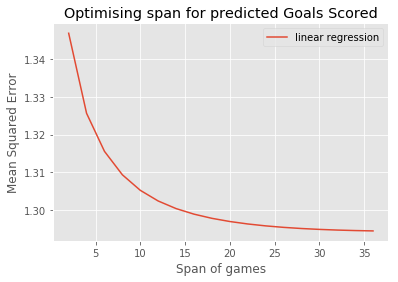

In [19]:
cv_scores = []
lowest_span = 2
for span in range(2, 38, 2):
    ema_output = ema_no_reset(training, span=span,feature_cols=features)
    ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna() ## this contains our target variable
    ema_target = ema_target[ema_target["t_Goals"]<6]
    ema_target = ema_target.dropna()
    error = optimise_alpha(ema_target,features+calculated_features,"t_Goals",lm.LinearRegression())
    cv_scores.append(error)
    if error == max(cv_scores):
        lowest_span = span

plt.style.use('ggplot')
plt.plot(list(range(2, 38, 2)), (pd.Series(cv_scores)*-1), label="linear regression") # Plot our result
plt.title("Optimising span for predicted Goals Scored")
plt.xlabel("Span of games")
plt.ylabel("Mean Squared Error")
plt.legend()
print("The lowest span occured at " +str(lowest_span))
print("The lowest error was " +str(max(cv_scores)))

**Let's compare the exponential moving average scores to the simple moving average scores**

The lowest span occured at 36


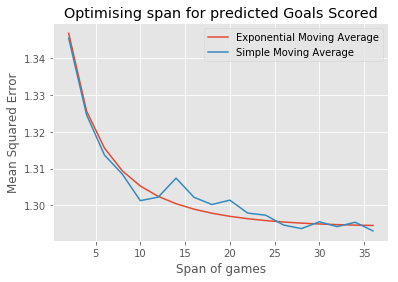

In [20]:
cv_scores = []
lowest_span = 2
for span in range(2, 38, 2):
    ema_output = ema_no_reset(training, span=span,feature_cols=features)
    ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna() ## this contains our target variable
    ema_target = ema_target[ema_target["t_Goals"]<6]
    error = optimise_alpha(ema_target,features+calculated_features,"t_Goals",lm.LinearRegression())
    cv_scores.append(error)
    if error == max(cv_scores):
        lowest_span = span

#Repeat the same for moving average
cv_scores_2 =[]
lowest_span_2 = 2
for span in range(2, 38, 2):
    ema_output = moving_average_no_reset(training, span=span,feature_cols=features)
    ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna() ## this contains our target variable
    ema_target = ema_target[ema_target["t_Goals"]<6]
    ema_target = ema_target.dropna()
    error = optimise_alpha(ema_target,features+calculated_features,"t_Goals",lm.LinearRegression())
    cv_scores_2.append(error)
    if error == max(cv_scores):
        lowest_span_2 = span

plt.style.use('ggplot')
plt.plot(list(range(2, 38, 2)), (pd.Series(cv_scores)*-1), label="Exponential Moving Average") # Plot our result
plt.plot(list(range(2, 38, 2)), (pd.Series(cv_scores_2)*-1), label="Simple Moving Average")
plt.title("Optimising span for predicted Goals Scored")
plt.xlabel("Span of games")
plt.ylabel("Mean Squared Error")
plt.legend()
print("The lowest span occured at " +str(lowest_span))

### Summary
The moving average graph looks a bit erratic, so for now we will use the exponential moving average

Next let's look at how different models compare over different time periods

## Best Span for Multiple Models

**We will now plot similar graphs for various different models to see which models perform best**

In [21]:
model_list ={"Linear Regression":lm.LinearRegression(),
             "Lasso Regression":lm.Lasso(alpha=0.5),
             "Ridge Regression":lm.Ridge(alpha=0.5),
            "Random Forest Regressor 10":ensemble.RandomForestRegressor(n_estimators=10,random_state=42),
             "Random Foreset 50 estimators":ensemble.RandomForestRegressor(n_estimators=50, random_state=42, max_depth = 2),
             "Bayesian Ridge":linear_model.BayesianRidge(),
             "Support Vector Machine":svm.SVR(gamma ="auto"),
             "KNN":neighbors.KNeighborsRegressor(),
             "Tree Depth 2":tree.DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=42),
             "Tree Depth 5":tree.DecisionTreeRegressor(max_depth=5, min_samples_leaf=50, random_state=42)
            }

### Run Multiple Models

In [22]:
model_scores = []
best_score = np.float("inf")
best_span = np.float()
best_model= ""
#mod_best = {"best_model":str(),"best_score":np.float("inf"),"best_span":np.float("inf")}
mod_best = {"best_model":str(),"best_score":np.float("inf"),"best_span":np.float()}

def best_span(mod,target,tracking):
    '''
    This function runs a specified model over a span of 2 to 38 games
    mod: a model function
    target: target variable that you want to model against
    tracking: this is a dictionary of containing {best_model,best_score,best_span} to keep track of the best model
    '''
    # Iterate over a range of spans
    for span in range(2, 38, 2):
        ema_output = ema_no_reset(training, span=span,feature_cols=features)
        ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
        ema_target = ema_target[ema_target[target]<6]
        ema_target = ema_target.dropna()
        
        mod_score = optimise_alpha(ema_target,features+calculated_features,target,mod)
        cv_scores.append(mod_score)
        
        if mod_score * -1 < tracking["best_score"]:
            best_score = mod_score * -1
            best_span = span
            best_model = mod
            tracking["best_model"]=best_model
            tracking["best_score"]=best_score
            tracking["best_span"]=best_span
    return cv_scores,tracking

In [23]:
for i in model_list.values():
    cv_scores = []
    score,tracking = best_span(i, "t_Goals", mod_best)
    model_scores.append(score)
    print(str(i) + " " +  datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp()).isoformat())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False) 2020-05-23T14:02:35.391893
Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 2020-05-23T14:02:49.052597
Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 2020-05-23T14:03:01.843626
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 2020-05-23T14:03:49.409873
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto'

### Plot Results

{'best_model': Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'best_score': 1.2905733946273847, 'best_span': 36}


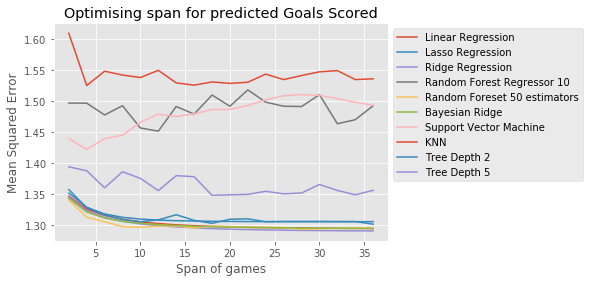

In [24]:
plt.style.use('ggplot')
for i in range(0,len(model_scores)):
#for i in (0,2,3):
    plt.plot(list(range(2, 38, 2)), (pd.Series(model_scores[i])*-1), label=list(model_list.keys())[i]) # Plot our result
plt.title("Optimising span for predicted Goals Scored")
plt.xlabel("Span of games")
plt.ylabel("Mean Squared Error")
plt.legend(bbox_to_anchor=[1,1])
print(mod_best)

In [25]:
## Looking at the best score for each model
for i in range(0,len(model_scores)):
    print(str(list(model_list.keys())[i]) + " " + str(max(model_scores[i])))


Linear Regression -1.294520815670107
Lasso Regression -1.3054773822051535
Ridge Regression -1.2905733946273847
Random Forest Regressor 10 -1.451646549718721
Random Foreset 50 estimators -1.2932099773758157
Bayesian Ridge -1.294528210897423
Support Vector Machine -1.4221635377844941
KNN -1.5254241267881121
Tree Depth 2 -1.3014436563016496
Tree Depth 5 -1.3481370103690957


### Summary
Ridge Regression appears to have the best performance over 36 games. <br>
There's not a lot of difference between Ridge Regresssion, linear regression and Random Forest Regressor (with 50 estimators). <br>
Interestingly the Random Forest regressor performs best over a shorter period of time, might be worth considering for promoted teams with no history.

## EMA + Span Function

In [26]:
def ewm_model_feature_creation(df,span,avg_features,mod_features,target_var):
    '''
    Performs EWM on dataset and joins onto to target goals dataset
    df: fixtures dataframe
    span:number of games for moving average
    avg_features: features for which moving average should be performed on
    model_features: features to be retained for modeling
    target_var: target_variable for the model
    '''
    ema_output = ema_no_reset(df, span=span,feature_cols=avg_features)
    ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
    ema_target = ema_target[ema_target[target_var]<6]
    return ema_target

## Scaling features
Scaling features tends to improve performance so we will look at a couple of methods to scale our variables

In [27]:
standard_scaler = StandardScaler()
minmax= MinMaxScaler()

ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target = ema_target.dropna()

ema_scaled = ema_target.copy()
ema_scaled[features] = standard_scaler.fit_transform(ema_scaled[features])
ema_scaled.head()

,matchid,f_Team,gameweek,season,f_HmGame,fixture,matchdate,gw_no,f_Goals,f_xG Conceded,f_Shots On Target,f_Touches - Penalty Area,f_Shots On Target Conceded,f_US xG Conceded,f_Touches - Final Third,f_xG Expected Goals,f_Points,f_xA Expected Assists,f_Passes - Final Third - Successful Conceded,f_Goals Conceded,f_Goal Attempts,f_Shots Conceded,f_Touches - Penalty Area Conceded,f_Passes - Final Third - Successful,f_Goals From Penalties,f_Shots - Inside Box,f_xG Open Play Conceded,f_Big Chances Conceded,f_Goal Attempts In Box Conceded,f_Possession,f_US xG,f_Chances Conceded,f_Big Chances Total,f_Touches - Final Third Conceded,f_xG Open Play,f_Chances Created,f_Touches - Final Third log,f_netxg,f_xGRatio,f_ShotsRatio,f_ShOnTargetRatio,f_HmGameFut,t_Goals,t_Goals Conceded,t_US xG,t_US xG Conceded
40,/matches/755324/,Manchester United,Gameweek 3,2014,-0.397674,Burnley vs Manchester United,2014-08-30 12:45:00,3,-0.766676,-0.520626,-0.149308,-0.774320,-0.762113,-3.041724,1.205302,-0.510361,-1.894349,-0.485653,-2.331066,0.470213,-0.356851,-1.991255,-2.887234,1.278786,-1.431936,-1.250647,-0.51711,-4.182072,-2.802243,1.063297,-0.657889,-1.006839,-0.179912,-2.739299,-0.491245,-0.795598,1.409375,0.573154,0.687488,0.596394,0.332558,0,0,0,0.467281,0.513746
41,/matches/755324/,Burnley,Gameweek 3,2014,-0.397674,Burnley vs Manchester United,2014-08-30 12:45:00,3,-1.907883,-0.520626,-2.512270,-1.177947,-0.727129,0.889786,-0.479642,-0.510361,-3.013264,-0.485653,0.513634,1.886701,-0.950356,-0.961500,-1.335311,-0.750859,-1.431936,-0.881259,-0.51711,1.167347,-0.673582,-1.186262,-1.889204,-1.065673,-2.037673,-0.874757,-0.491245,-1.247559,-0.263277,-0.891408,0.289663,0.501321,0.140975,1,0,0,0.513746,0.467281
42,/matches/755327/,Stoke City,Gameweek 3,2014,-0.397674,Manchester City vs Stoke City,2014-08-30 15:00:00,3,-1.846196,-0.520626,-1.535403,0.156746,-3.245971,-1.466299,0.474579,-0.510361,-1.894349,-0.485653,-2.014536,-0.946275,1.188612,-2.015065,-1.928999,0.227780,-1.431936,0.707967,-0.51711,-1.469690,-2.153508,1.556044,-0.708879,-2.367370,-1.082990,-1.544066,-0.491245,0.231585,0.679821,0.143309,0.537278,0.660200,0.161175,0,1,0,0.299792,0.891768
43,/matches/755327/,Manchester City,Gameweek 3,2014,0.400654,Manchester City vs Stoke City,2014-08-30 15:00:00,3,2.595256,-0.520626,0.339126,0.305320,-3.210987,-1.300139,0.136066,-0.510361,3.518783,-0.485653,0.495733,-2.362763,-0.779944,-0.532932,0.591573,1.002735,-1.431936,0.003553,-0.51711,-1.469690,0.411022,0.663469,0.311280,-0.249355,2.580926,0.757122,-0.491245,-0.288855,0.407070,0.461972,0.599235,0.487926,0.409898,1,0,1,0.891768,0.299792
44,/matches/755328/,Crystal Palace,Gameweek 3,2014,0.400654,Newcastle United vs Crystal Palace,2014-08-30 15:00:00,3,-0.766676,-0.520626,-1.046970,-1.433000,3.698338,0.655080,-1.562302,-0.510361,-3.013264,-0.485653,1.114146,3.465074,-2.630974,1.205151,0.720032,-1.399770,-1.431936,-2.719607,-0.51711,2.561210,0.471840,-2.202024,-2.508192,1.625972,-2.037673,1.715906,-0.491245,-1.952891,-1.996104,-1.049766,0.214420,0.297111,0.460888,0,3,3,1.660560,1.697760


In [28]:
#test function
model_features = features+calculated_features

ema_target = ewm_model_feature_creation(training, 36,features,model_features,"t_Goals")

ema_scaled = ema_target.copy()
ema_scaled[features] = standard_scaler.fit_transform(ema_scaled[features])
ema_scaled.head()

,matchid,f_Team,gameweek,season,f_HmGame,fixture,matchdate,gw_no,f_Goals,f_xG Conceded,f_Shots On Target,f_Touches - Penalty Area,f_Shots On Target Conceded,f_US xG Conceded,f_Touches - Final Third,f_xG Expected Goals,f_Points,f_xA Expected Assists,f_Passes - Final Third - Successful Conceded,f_Goals Conceded,f_Goal Attempts,f_Shots Conceded,f_Touches - Penalty Area Conceded,f_Passes - Final Third - Successful,f_Goals From Penalties,f_Shots - Inside Box,f_xG Open Play Conceded,f_Big Chances Conceded,f_Goal Attempts In Box Conceded,f_Possession,f_US xG,f_Chances Conceded,f_Big Chances Total,f_Touches - Final Third Conceded,f_xG Open Play,f_Chances Created,f_Touches - Final Third log,f_netxg,f_xGRatio,f_ShotsRatio,f_ShOnTargetRatio,f_HmGameFut,t_Goals,t_Goals Conceded,t_US xG,t_US xG Conceded
40,/matches/755324/,Manchester United,Gameweek 3,2014,-0.397674,Burnley vs Manchester United,2014-08-30 12:45:00,3,-0.766676,-0.520626,-0.149308,-0.774320,-0.762113,-3.041724,1.205302,-0.510361,-1.894349,-0.485653,-2.331066,0.470213,-0.356851,-1.991255,-2.887234,1.278786,-1.431936,-1.250647,-0.51711,-4.182072,-2.802243,1.063297,-0.657889,-1.006839,-0.179912,-2.739299,-0.491245,-0.795598,1.409375,0.573154,0.687488,0.596394,0.332558,0,0,0,0.467281,0.513746
41,/matches/755324/,Burnley,Gameweek 3,2014,-0.397674,Burnley vs Manchester United,2014-08-30 12:45:00,3,-1.907883,-0.520626,-2.512270,-1.177947,-0.727129,0.889786,-0.479642,-0.510361,-3.013264,-0.485653,0.513634,1.886701,-0.950356,-0.961500,-1.335311,-0.750859,-1.431936,-0.881259,-0.51711,1.167347,-0.673582,-1.186262,-1.889204,-1.065673,-2.037673,-0.874757,-0.491245,-1.247559,-0.263277,-0.891408,0.289663,0.501321,0.140975,1,0,0,0.513746,0.467281
42,/matches/755327/,Stoke City,Gameweek 3,2014,-0.397674,Manchester City vs Stoke City,2014-08-30 15:00:00,3,-1.846196,-0.520626,-1.535403,0.156746,-3.245971,-1.466299,0.474579,-0.510361,-1.894349,-0.485653,-2.014536,-0.946275,1.188612,-2.015065,-1.928999,0.227780,-1.431936,0.707967,-0.51711,-1.469690,-2.153508,1.556044,-0.708879,-2.367370,-1.082990,-1.544066,-0.491245,0.231585,0.679821,0.143309,0.537278,0.660200,0.161175,0,1,0,0.299792,0.891768
43,/matches/755327/,Manchester City,Gameweek 3,2014,0.400654,Manchester City vs Stoke City,2014-08-30 15:00:00,3,2.595256,-0.520626,0.339126,0.305320,-3.210987,-1.300139,0.136066,-0.510361,3.518783,-0.485653,0.495733,-2.362763,-0.779944,-0.532932,0.591573,1.002735,-1.431936,0.003553,-0.51711,-1.469690,0.411022,0.663469,0.311280,-0.249355,2.580926,0.757122,-0.491245,-0.288855,0.407070,0.461972,0.599235,0.487926,0.409898,1,0,1,0.891768,0.299792
44,/matches/755328/,Crystal Palace,Gameweek 3,2014,0.400654,Newcastle United vs Crystal Palace,2014-08-30 15:00:00,3,-0.766676,-0.520626,-1.046970,-1.433000,3.698338,0.655080,-1.562302,-0.510361,-3.013264,-0.485653,1.114146,3.465074,-2.630974,1.205151,0.720032,-1.399770,-1.431936,-2.719607,-0.51711,2.561210,0.471840,-2.202024,-2.508192,1.625972,-2.037673,1.715906,-0.491245,-1.952891,-1.996104,-1.049766,0.214420,0.297111,0.460888,0,3,3,1.660560,1.697760


### Standard Scaler

In [29]:
def best_span_scaled(mod,target,features,scaler, tracking):
    """
    mod: Model to be used for the prediction
    target: target variable
    features: list of features to be scaled an used in the prediction
    scaler: Type of scaler to be used
    tracking: dictionary tracking the best performance
    """
    # Iterate over a range of spans
    for span in range(2, 38, 2):
        ema_output = ema_no_reset(training, span=span,feature_cols=features)
        ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
        ema_target = ema_target[ema_target[target]<6]
        ema_target[features] = scaler.fit_transform(ema_target[features])
        
        mod_score = optimise_alpha(ema_target,features+calculated_features,target,mod)
        cv_scores.append(mod_score)
        
        if mod_score * -1 < tracking["best_score"]:
            best_score = mod_score * -1
            best_span = span
            best_model = mod
            tracking["best_model"]=best_model
            tracking["best_score"]=best_score
            tracking["best_span"]=best_span
    return cv_scores,tracking

In [30]:
best_score = np.float()
best_span = 0
best_model=""
mod_best = {"best_model":str(),"best_score":np.float("inf"),"best_span":np.float()}

model_scores = []

for i in model_list.values():
    cv_scores = []
    score,tracking = best_span_scaled(i, "t_Goals",features,standard_scaler,mod_best)
    model_scores.append(score)
    print(str(i) + " " +  datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp()).isoformat())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False) 2020-05-23T14:07:03.844886
Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 2020-05-23T14:07:16.742542
Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 2020-05-23T14:07:29.620590
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 2020-05-23T14:08:19.544482
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto'

{'best_model': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False), 'best_score': 1.2824226957309732, 'best_span': 36}


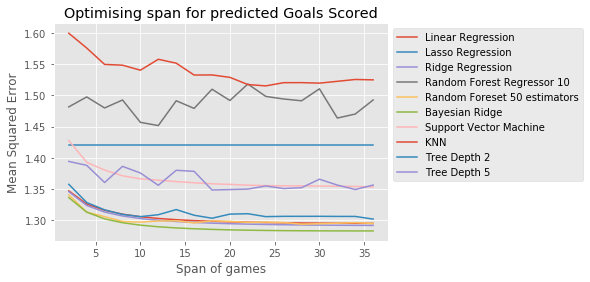

In [31]:
plt.style.use('ggplot')
for i in range(0,len(model_scores)):
#for i in (0,2,3):
    plt.plot(list(range(2, 38, 2)), (pd.Series(model_scores[i])*-1), label=list(model_list.keys())[i]) # Plot our result
plt.title("Optimising span for predicted Goals Scored")
plt.xlabel("Span of games")
plt.ylabel("Mean Squared Error")
plt.legend(bbox_to_anchor=[1,1])
print(mod_best)

In [32]:
for i in range(0,len(model_scores)):
    print(str(list(model_list.keys())[i]) + " " + str(max(model_scores[i])))

Linear Regression -1.2945208156701071
Lasso Regression -1.419884438907926
Ridge Regression -1.2912100890231497
Random Forest Regressor 10 -1.451646549718721
Random Foreset 50 estimators -1.2932099773758157
Bayesian Ridge -1.2824226957309732
Support Vector Machine -1.3531605352670686
KNN -1.5153423583747305
Tree Depth 2 -1.3014436563016496
Tree Depth 5 -1.3481370103690957


#### Summary
Bayesian Ridge improved to being the best model with a mean squared error of 1.282.<br>
Not a huge improvement otherwise in other models - the next best is still ridge regression at around 1.291.

### MinMax Scaler

In [33]:
best_score = np.float()
best_span = 0
best_model=""
mod_best = {"best_model":str(),"best_score":np.float("inf"),"best_span":np.float()}

model_scores = []

for i in model_list.values():
    cv_scores = []
    score,tracking = best_span_scaled(i, "t_Goals",features,minmax,mod_best)
    model_scores.append(score)
    print(str(i) + " " +  datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp()).isoformat())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False) 2020-05-23T14:11:07.471113
Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 2020-05-23T14:11:20.663592
Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 2020-05-23T14:11:34.062475
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 2020-05-23T14:12:22.365043
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto'

{'best_model': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False), 'best_score': 1.2838109234964072, 'best_span': 32}


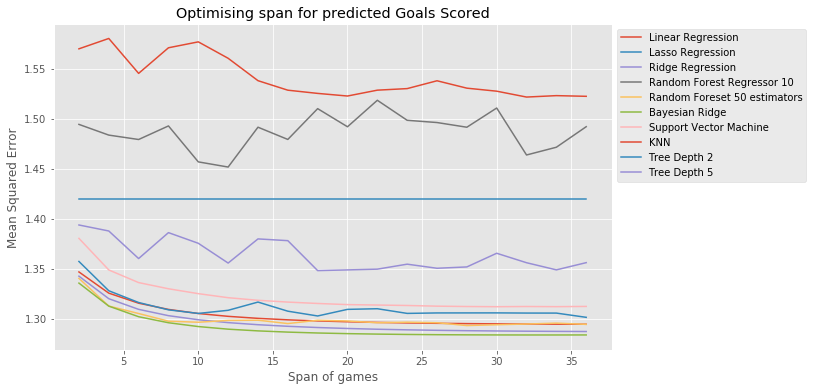

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
for i in range(0,len(model_scores)):
#for i in (0,2,3):
    plt.plot(list(range(2, 38, 2)), (pd.Series(model_scores[i])*-1), label=list(model_list.keys())[i]) # Plot our result
plt.title("Optimising span for predicted Goals Scored")
plt.xlabel("Span of games")
plt.ylabel("Mean Squared Error")
plt.legend(bbox_to_anchor=[1,1])
print(mod_best)

In [35]:
for i in range(0,len(model_scores)):
    print(str(list(model_list.keys())[i]) + " " + str(max(model_scores[i])))

Linear Regression -1.2945208156701073
Lasso Regression -1.419884438907926
Ridge Regression -1.2872750196634324
Random Forest Regressor 10 -1.451646549718721
Random Foreset 50 estimators -1.2932099773758157
Bayesian Ridge -1.2838109234964072
Support Vector Machine -1.312063054744075
KNN -1.5215910999243611
Tree Depth 2 -1.3014436563016496
Tree Depth 5 -1.3481370103690957


#### Summary
Bayesian Ridge performs the best, Ridge Regression improves as well  - Still not quite as good as the standard scaler

## Plot residuals
To get a good understanding of how our predictions compare to reality we're going to use the cross_val_predict method to come up with a set of predictions for goals scored based on our data. We'll the plot the predicted goals against the actual goals scored

In [36]:
model_list["Bayesian Ridge"]

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

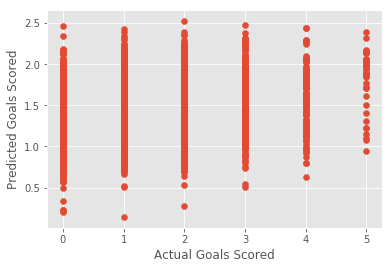

In [37]:
ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])

df = ema_target.dropna()
X = df[features + calculated_features]
y = df["t_Goals"]
y = y.apply(lambda x: float(x))

kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
predicted = cross_val_predict(model_list["Bayesian Ridge"], X, y, cv=kfold)
residual = y-predicted
plt.scatter(y,predicted)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual Goals Scored')
plt.ylabel('Predicted Goals Scored')
plt.show()

#### Summary
To be honest this doesn't look particularly good. We'd want to see a better correlation between Actual Goals and predicted goals. We can see that as the Actual Goals Scored increases our prediction range tends to have a higher minimum value, but overall it's not great. <br>
There could be a few reasons for this:
- We're only taking into account one Team's statistic - opponent strength isn't coming in to it.
- There's not a lot of difference in performance between scoring 0 goals and 1 goal, or 1 goal and 2 goals.
- Perhaps linear regression isn't the best way to approach this and we're better off using some kind of classification method
- Perhaps we're better off using classification to predict whether or not a team will score or concede, rather than how many a team will score or concede

For now though we'll continue with this process to see if there are any other improvements we can make

## Feature Selection and Variable Importance

Sources: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b <br>
https://scikit-learn.org/stable/modules/feature_selection.html <br>
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

### SelectKBest

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression

Looking at feature importance for unscaled features <br>
Use the SelectKBest package from sklearn to identify the best features

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

In [39]:
ema_output = ema_no_reset(training, span=span,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]



X = ema_target[features + calculated_features + ["f_HmGameFut"]]  #independent columns
y = ema_target["t_Goals"]    #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
bestfeatures.fit(X,y)

dfscores = pd.DataFrame(bestfeatures.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs       Score
3              f_Touches - Penalty Area  279.522016
5                     f_Chances Created  266.611138
2               f_Touches - Final Third  263.180502
8                       f_Goal Attempts  261.755385
29          f_Touches - Final Third log  260.721849
25                              f_US xG  255.735386
11                    f_Shots On Target  254.726103
9                  f_Shots - Inside Box  252.456700
32                         f_ShotsRatio  247.911021
4   f_Passes - Final Third - Successful  244.254531


In [40]:
bestfeatures.pvalues_

array([2.26731246e-07, 2.41467939e-45, 8.94189581e-57, 4.87620344e-60,
       5.65612525e-53, 1.84042048e-57, 1.73883301e-44, 3.43210948e-06,
       1.72518987e-56, 1.26567123e-54, 5.08206458e-47, 4.43116307e-55,
       1.94111605e-32, 3.00717572e-35, 1.22069812e-25, 8.42933223e-10,
       9.32850337e-06, 2.31749145e-04, 5.25264152e-04, 1.28477817e-18,
       1.07379253e-01, 4.59592407e-37, 1.79077516e-37, 1.47991667e-35,
       1.25420250e-01, 2.77916368e-55, 1.59378738e-27, 2.96806592e-37,
       7.38906571e-35, 2.77910473e-56, 3.05429229e-51, 2.86580868e-51,
       1.03829771e-53, 3.14558625e-17, 4.58729986e-16])

#### Summary
Touches in the Penalty Area has the best score, followed by Chances Created. Expected Goals (from Understat) is the highest xG predictor, but suprisingly is a less strong predictor than 

### Correlation Matrix

**Using a correlation matrix**<br>
Plot a correlatioin matrix to identify best features as well as colinearity

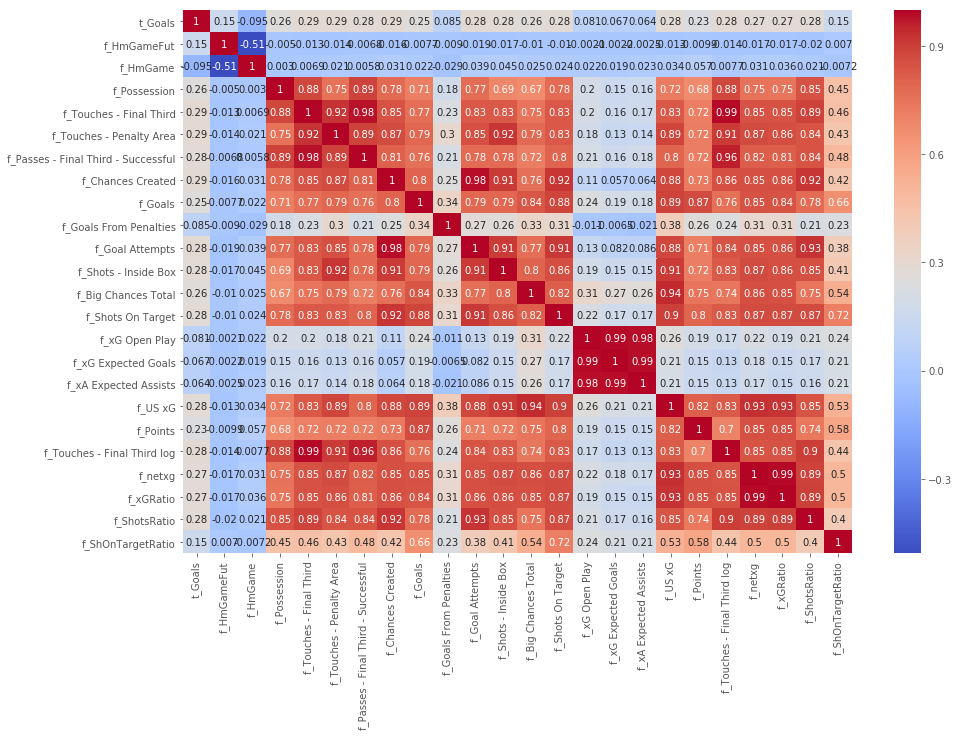

In [41]:
plt.figure(figsize=(15,10))
sns.heatmap(ema_target[["t_Goals","f_HmGameFut"] + att_features+calculated_features].corr(),cmap="coolwarm",annot =True)

In [42]:
ema_target[["t_Goals","f_HmGameFut"] + att_features+calculated_features].corr()["t_Goals"].sort_values(ascending =False)

t_Goals                                1.000000
f_Touches - Penalty Area               0.293291
f_Chances Created                      0.287008
f_Touches - Final Third                0.285307
f_Goal Attempts                        0.284596
f_Touches - Final Third log            0.284079
f_US xG                                0.281567
f_Shots On Target                      0.281054
f_Shots - Inside Box                   0.279898
f_ShotsRatio                           0.277563
f_Passes - Final Third - Successful    0.275665
f_xGRatio                              0.271211
f_netxg                                0.271138
f_Big Chances Total                    0.259728
f_Possession                           0.255034
f_Goals                                0.252596
f_Points                               0.230876
f_ShOnTargetRatio                      0.153976
f_HmGameFut                            0.148222
f_Goals From Penalties                 0.085051
f_xG Open Play                         0

In [43]:
correlated_features = set()
correlation_matrix = ema_target[features+calculated_features].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'f_Goals', 'f_xG Conceded', 'f_Shots On Target', 'f_Touches - Penalty Area', 'f_Shots On Target Conceded', 'f_US xG Conceded', 'f_Touches - Final Third', 'f_xG Expected Goals', 'f_Points', 'f_xA Expected Assists', 'f_Passes - Final Third - Successful Conceded', 'f_Goal Attempts', 'f_Shots Conceded', 'f_netxg', 'f_Touches - Penalty Area Conceded', 'f_Passes - Final Third - Successful', 'f_ShotsRatio', 'f_Shots - Inside Box', 'f_xG Open Play Conceded', 'f_US xG', 'f_Chances Conceded', 'f_Big Chances Total', 'f_Touches - Final Third Conceded', 'f_Chances Created', 'f_xGRatio', 'f_Touches - Final Third log'}


In [44]:
uncorrelated_features = list(correlation_matrix.drop(correlated_features,axis=1).columns)
print(uncorrelated_features)

['f_HmGame', 'f_Possession', 'f_Goals From Penalties', 'f_Goal Attempts In Box Conceded', 'f_Big Chances Conceded', 'f_xG Open Play', 'f_Goals Conceded', 'f_ShOnTargetRatio']


#### Summary
There are a few observations from this correlation plot. <br>
Firstly - Nothing correlates particularly strongly with "t_Goals", our target variable". <br>
The results seem to be consistent with what we got from the SelectKBest methods earlier. Touches in the Penalty area correlates the most, followed by Chances Create, Touches in the Final Third, Goal Attempts. <br>

What is also clear is that there is a lot of multi-colinearity. <br>
Touches in the Penalty Area, Touches in the Final Third, Successful Passes in the final third, Shots on Target, Shots inside the box etc, all correlate heavily with each other. 

This is something we're going to have to deal with later on, but for now we will leave all the variables in.

### Using Statsmodels to identify key variables
We're going to use the stats models package to run OLS regression using our variables and use statistical methods to identify significant variables.

Here we are interested in variables with a Pvalue of less than 0.05, denoting 95% confidence that they affect the target variable

#### Regresssion using all features

In [45]:
##We will clean up the naming conventions of our variables to remove spaces and dashes.

ema_output = ema_no_reset(training, span=span,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])
ema_target.columns = ema_target.columns.str.replace(' ', '_')
ema_target.columns = ema_target.columns.str.replace('-', '')

features_ns = [i.replace(' ', '_') for i in features + calculated_features +["f_HmGameFut"]]
features_ns = [i.replace('-', '') for i in features_ns]

X = ema_target[features_ns].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

#print(features_ns)
formula = 't_Goals ~ ' + ' + '.join(x for x in features_ns)
#print(formula)
X1 = X.copy()
X1 = sm.add_constant(X1)

# model = smf.ols(
#     formula,
#     data=ema_target
# ).fit()

model = sm.OLS(y,X1).fit()

model.summary()

C:\Users\Byron\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                t_Goals   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     12.17
Date:                Sat, 23 May 2020   Prob (F-statistic):           6.96e-62
Time:                        14:15:00   Log-Likelihood:                -4542.2
No. Observations:                2972   AIC:                             9154.
Df Residuals:                    2937   BIC:                             9364.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -1.4340      2.028     -0.707      0.480      -5.411       2.543
f_HmGame                                      -0.0321      0.025     -1.297      0.195      -0.081       0.016
f_Possession                                   0.0362      0.071      0.511      0.610      -0.103       0.175
f_Touches__Final_Third                        -0.0050      0.361     -0.014      0.989      -0.712       0.702
f_Touches__Penalty_Area                        0.2264      0.100      2.255      0.024       0.030       0.423
f_Passes__Final_Third__Successful              0.0096      0.185      0.052      0.959      -0.354       0.373
f_Chances_Created                              0.0811      0.136      0.597      0.551      -0.185       0.348
f_Goals                                       -0.0503      0.074     -0.682      0.495      -0.195       0.094
f_Goals_From_Penalties                        -0.0208      0.027     -0.764      0.445      -0.074       0.033
f_Goal_Attempts                               -0.2277      0.331     -0.688      0.491      -0.876       0.421
f_Shots__Inside_Box                           -0.0942      0.085     -1.110      0.267      -0.260       0.072
f_Big_Chances_Total                            0.0903      0.081      1.113      0.266      -0.069       0.249
f_Shots_On_Target                              0.1567      0.290      0.541      0.589      -0.411       0.724
f_Goal_Attempts_In_Box_Conceded               -0.0134      0.094     -0.143      0.886      -0.197       0.170
f_Shots_Conceded                               0.3153      0.224      1.407      0.160      -0.124       0.755
f_Shots_On_Target_Conceded                     0.0098      0.051      0.190      0.849      -0.091       0.111
f_Big_Chances_Conceded                         0.0081      0.071      0.113      0.910      -0.132       0.148
f_xG_Open_Play                                -0.0756      0.242     -0.312      0.755      -0.551       0.400
f_xG_Expected_Goals                            0.5012      0.265      1.891      0.059      -0.019       1.021
f_xA_Expected_Assists                         -0.3230      0.145     -2.227      0.026      -0.607      -0.039
f_Goals_Conceded                              -0.0567      0.054     -1.044      0.296      -0.163       0.050
f_xG_Conceded                                 -0.6085      0.254     -2.399      0.017      -1.106      -0.111
f_Touches__Final_Third_Conceded                0.3089      0.150      2.055      0.040       0.014       0.604
f_Touches__Penalty_Area_Conceded              -0.0865      0.094     -0.920      0.358      -0.271       0.098
f_Passes__Final_Third__Successful_Conceded    -0.1950      0.126     -1.543      0.123

**Let's look at the features that are significant**

In [46]:
round(model.pvalues.iloc[np.where(model.pvalues<0.1)],5).sort_values()

f_HmGameFut                        0.00000
f_xG_Conceded                      0.01652
f_Touches__Penalty_Area            0.02422
f_xA_Expected_Assists              0.02600
f_xG_Open_Play_Conceded            0.02891
f_Touches__Final_Third_Conceded    0.03999
f_xG_Expected_Goals                0.05873
dtype: float64

#### Regression on attacking features

In [47]:
features_ns = [i.replace(' ', '_') for i in att_features + calculated_features +["f_HmGameFut"]]
features_ns = [i.replace('-', '') for i in features_ns]

X = ema_target[features_ns].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))


X1 = X.copy()
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                t_Goals   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     17.37
Date:                Sat, 23 May 2020   Prob (F-statistic):           1.47e-65
Time:                        14:15:00   Log-Likelihood:                -4549.2
No. Observations:                2972   AIC:                             9146.
Df Residuals:                    2948   BIC:                             9290.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.9255      1.294      0.715      0.475      -1.612       3.463
f_HmGame                             -0.0403      0.024     -1.663      0.096      -0.088       0.007
f_Possession                          0.0099      0.059      0.169      0.866      -0.106       0.126
f_Touches__Final_Third               -0.1010      0.349     -0.290      0.772      -0.785       0.583
f_Touches__Penalty_Area               0.2505      0.094      2.656      0.008       0.066       0.435
f_Passes__Final_Third__Successful     0.0713      0.173      0.413      0.680      -0.267       0.410
f_Chances_Created                     0.0815      0.132      0.619      0.536      -0.177       0.340
f_Goals                              -0.0603      0.062     -0.974      0.330      -0.182       0.061
f_Goals_From_Penalties               -0.0065      0.026     -0.257      0.797      -0.057       0.043
f_Goal_Attempts                       0.1234      0.245      0.503      0.615      -0.357       0.604
f_Shots__Inside_Box                  -0.0788      0.081     -0.968      0.333      -0.238       0.081
f_Big_Chances_Total                   0.1009      0.078      1.289      0.197      -0.053       0.254
f_Shots_On_Target                     0.0573      0.279      0.205      0.837      -0.490       0.605
f_xG_Open_Play                        0.0322      0.195      0.165      0.869      -0.350       0.414
f_xG_Expected_Goals                   0.2967      0.199      1.488      0.137      -0.094       0.688
f_xA_Expected_Assists                -0.2905      0.139     -2.091      0.037      -0.563      -0.018
f_US_xG                              -0.0848      0.144     -0.590      0.555      -0.366       0.197
f_Points                              0.0244      0.051      0.476      0.634      -0.076       0.125
f_Touches__Final_Third_log            0.0561      0.223      0.251      0.802      -0.381       0.493
f_netxg                              -0.2108      0.403     -0.522      0.601      -1.002       0.580
f_xGRatio                             0.8406      2.062      0.408      0.684      -3.202       4.884
f_ShotsRatio                         -0.4195      1.143     -0.367      0.714      -2.660       1.821
f_ShOnTargetRatio                     0.0846      3.231      0.026      0.979      -6.251       6.420
f_HmGameFut                           0.3220      0.048      6.709      0.000       0.228       0.416
==============================================================================
Omnibus:                      174.461   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.968
Skew:                           0.645   Prob(JB):                     1.88e-45
Kurtosis:    

In [48]:
round(model.pvalues.iloc[np.where(model.pvalues<0.1)],5).sort_values()

f_HmGameFut                0.00000
f_Touches__Penalty_Area    0.00794
f_xA_Expected_Assists      0.03660
f_HmGame                   0.09639
dtype: float64

#### Regression on uncorrelated features

In [49]:
features_ns = [i.replace(' ', '_') for i in uncorrelated_features]
features_ns = [i.replace('-', '') for i in features_ns]

X = ema_target[features_ns].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))


X1 = X.copy()
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                t_Goals   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     32.56
Date:                Sat, 23 May 2020   Prob (F-statistic):           1.80e-49
Time:                        14:15:00   Log-Likelihood:                -4612.9
No. Observations:                2972   AIC:                             9244.
Df Residuals:                    2963   BIC:                             9298.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.0099      0.217      4.646      0.000       0.584       1.436
f_HmGame                           -0.1149      0.021     -5.456      0.000      -0.156      -0.074
f_Possession                        0.2097      0.032      6.511      0.000       0.147       0.273
f_Goals_From_Penalties              0.0423      0.022      1.936      0.053      -0.001       0.085
f_Goal_Attempts_In_Box_Conceded    -0.0642      0.034     -1.869      0.062      -0.132       0.003
f_Big_Chances_Conceded              0.0177      0.032      0.556      0.578      -0.045       0.080
f_xG_Open_Play                      0.0318      0.022      1.435      0.151      -0.012       0.075
f_Goals_Conceded                   -0.0529      0.032     -1.643      0.100      -0.116       0.010
f_ShOnTargetRatio                   0.9658      0.675      1.430      0.153      -0.358       2.290
==============================================================================
Omnibus:                      195.210   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.987
Skew:                           0.689   Prob(JB):                     9.40e-52
Kurtosis:                       3.029   Cond. No.                         56.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Summary
Stats models also confirms the Touches in the Penalty Area has a statistically signifcant impact on the model.

Depending which variable selection we use, Expected Assists also comes out as statistically significant as well as some defensive metrics.

"f_HmGame" and "f_HmGameFut" also have an impact. <br>
To clarify - "f_HmGame" is a weighted average of Home Games played in the fixture span (the feature is a boolean of 0 and 1). So if someone has a higher value for "f_HmGame", that means they have played an above average number of Home Games recently and the likelihood is that their next fixture is going to be Away. <br>

"f_HmGameFut" denotes whether or not this upcoming fixture for which we are predicting is a Home Game or not. We can see that this feature correlates positively with Goals Scored, which we would expect given that a basic assumption of sport is that a Home team has an advantage. <br>

We can also see that these two variables correlate negatively with each other, for the reasons explained above. <br>

For creating a goals scored prediction, which could equate to a team attacking strenght metric - I'm not sure if Home Advantage should be taken into account here and it may be worth removing these variables in future.

### Recursive Feature Selection
This is another method of selecting the best features depending on the model type we have chosen.

Sources: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

Model requires either a feature_importances method or a coef_ method, which excludes KNN and SVM regressors

Our list of models to compare for is below. <br>
model_list ={"Linear Regression":lm.LinearRegression(),
             "Lasso Regression":lm.Lasso(alpha=0.5),
             "Ridge Regression":lm.Ridge(alpha=0.5),
            "Random Forest Regressor 10":ensemble.RandomForestRegressor(n_estimators=10,random_state=42),
             "Random Foreset 50 estimators":ensemble.RandomForestRegressor(n_estimators=50, random_state=42, max_depth = 2),
             "Bayesian Ridge":linear_model.BayesianRidge(),
             "Support Vector Machine":svm.SVR(gamma ="auto"),
             "KNN":neighbors.KNeighborsRegressor(),
             "Tree Depth 2":tree.DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=42),
             "Tree Depth 5":tree.DecisionTreeRegressor(max_depth=5, min_samples_leaf=50, random_state=42)
            }

#### RFE on one estimator

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

ema_output = ema_no_reset(training, span=span,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])

X = ema_target[features + calculated_features +["f_HmGameFut"]].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

rfmod = lm.LinearRegression()

rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
rfecv.fit(X, y)
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 8


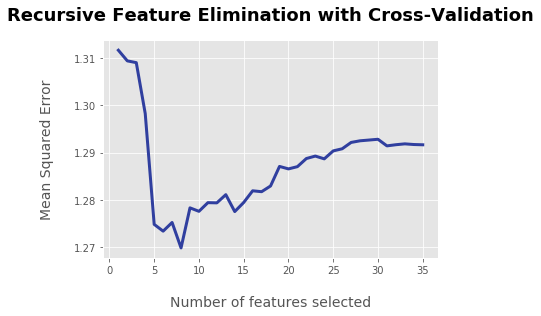

In [51]:
plt.figure(figsize=(6, 4))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_*-1, color='#303F9F', linewidth=3)

plt.show()

**Let's look at which variables have come out as the best variables to use**

In [52]:
pd.Series(rfecv.support_,index = X.columns).sort_values(ascending=False)
#pd.Series(rfecv.ranking_,index = X.columns).sort_values(ascending=False)

f_HmGameFut                                      True
f_xG Open Play Conceded                          True
f_ShOnTargetRatio                                True
f_xA Expected Assists                            True
f_xG Conceded                                    True
f_xG Expected Goals                              True
f_xGRatio                                        True
f_ShotsRatio                                     True
f_Chances Conceded                              False
f_Goal Attempts In Box Conceded                 False
f_Possession                                    False
f_Touches - Final Third                         False
f_Touches - Penalty Area                        False
f_Passes - Final Third - Successful             False
f_Chances Created                               False
f_Goals                                         False
f_Goals From Penalties                          False
f_Goal Attempts                                 False
f_Shots - Inside Box        

#### RFE with multiple estimators

In [53]:
model_list2 = model_list.copy()
del model_list2["KNN"]
del model_list2["Support Vector Machine"]

X = ema_target[features + calculated_features +["f_HmGameFut"]].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

cv_scores = []
n_features = []
for i in model_list2.values(): #select one from our list of models
    #print(i)
    rfmod = i
    rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    cv_scores.append(rfecv.grid_scores_)
    n_features.append(rfecv.n_features_)

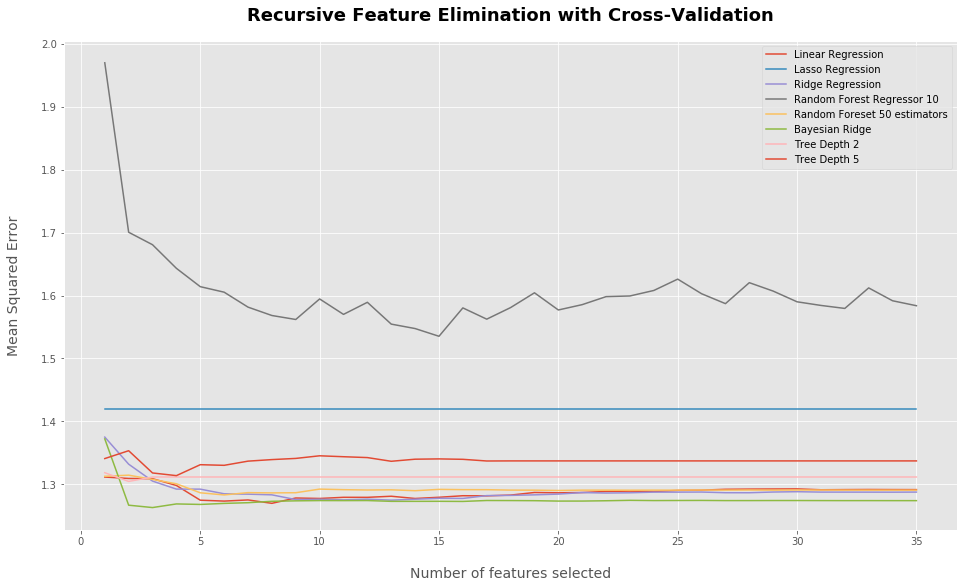

In [54]:
plt.figure(figsize=(16, 9))
for i in range(0,len(cv_scores)):
    plt.plot(range(1, len(cv_scores[i]) + 1), cv_scores[i]*-1, label=list(model_list2.keys())[i])
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.legend(bbox_to_anchor=[1,1])
plt.show()

**Number of features and best score using all features**

In [55]:
for i in range(0,len(cv_scores)):
    print(str(list(model_list2.keys())[i]) +": " + str(min(cv_scores[i]*-1)) + " number of features: " +str(n_features[i]))

Linear Regression: 1.269860244266866 number of features: 8
Lasso Regression: 1.4198025104175542 number of features: 1
Ridge Regression: 1.2749308270018496 number of features: 13
Random Forest Regressor 10: 1.5352648478642146 number of features: 15
Random Foreset 50 estimators: 1.2831803029925721 number of features: 6
Bayesian Ridge: 1.2631305398399115 number of features: 3
Tree Depth 2: 1.3046432749367587 number of features: 2
Tree Depth 5: 1.3138605046437886 number of features: 4


**Number of features and best score using attacking features**

In [56]:
## Number of features and best score using attacking features features
X = ema_target[att_features + calculated_features +["f_HmGameFut"]].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

cv_scores = []
n_features = []
for i in model_list2.values():
    #print(i)
    rfmod = i
    rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    cv_scores.append(rfecv.grid_scores_)
    n_features.append(rfecv.n_features_)
    
for i in range(0,len(cv_scores)):
    print(str(list(model_list2.keys())[i]) +": " + str(min(cv_scores[i]*-1)) + " number of features: " +str(n_features[i]))

Linear Regression: 1.2711916705216066 number of features: 8
Lasso Regression: 1.4198025104175542 number of features: 1
Ridge Regression: 1.2681395205523942 number of features: 7
Random Forest Regressor 10: 1.538546742251285 number of features: 13
Random Foreset 50 estimators: 1.2830148622705029 number of features: 9
Bayesian Ridge: 1.2630376750207837 number of features: 3
Tree Depth 2: 1.2946515223407409 number of features: 3
Tree Depth 5: 1.303219601497322 number of features: 4


#### Summary
Generally we can see that the models start to approach peak performance with only a few variables and that in some cases having more variables hurts the model performance.

This is is in line with our understanding that many of the variables are correlated with each other, and thus may not all be needed.

It also appears as if reducing the variables to just attacking variables generally results in a very small improvement in the models, although it's not always the case

#### Compare without home factor
Let's compare which features are selected if we exclude any kind of home and away impact

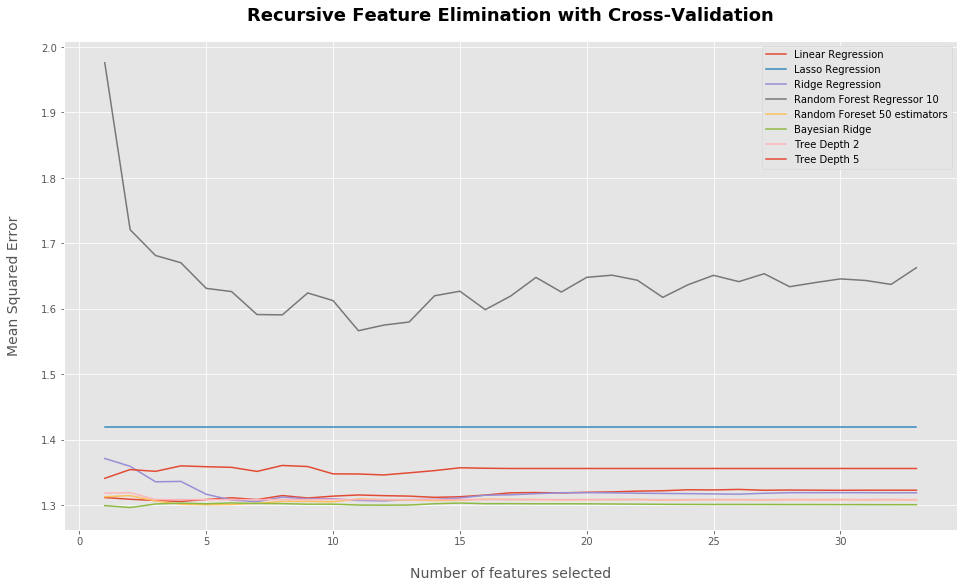

In [57]:
X = ema_target[features + calculated_features].copy()
X = X.drop("f_HmGame",axis=1)
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

cv_scores = []
n_features = []
for i in model_list2.values(): #select one from our list of models
    #print(i)
    rfmod = i
    rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    cv_scores.append(rfecv.grid_scores_)
    n_features.append(rfecv.n_features_)
    
plt.figure(figsize=(16, 9))
for i in range(0,len(cv_scores)):
    plt.plot(range(1, len(cv_scores[i]) + 1), cv_scores[i]*-1, label=list(model_list2.keys())[i])
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.legend(bbox_to_anchor=[1,1])
plt.show()

In [58]:
for i in range(0,len(cv_scores)):
    print(str(list(model_list2.keys())[i]) +": " + str(min(cv_scores[i]*-1)) + " number of features: " +str(n_features[i]))

Linear Regression: 1.3056493230853636 number of features: 4
Lasso Regression: 1.4198025104175542 number of features: 1
Ridge Regression: 1.3053378791284294 number of features: 7
Random Forest Regressor 10: 1.5665054686469344 number of features: 11
Random Foreset 50 estimators: 1.3006184595010561 number of features: 5
Bayesian Ridge: 1.2963216751593574 number of features: 2
Tree Depth 2: 1.3084455563057475 number of features: 3
Tree Depth 5: 1.3409831025247005 number of features: 1


#### Look at Best Model

Let's look out our best model and see how our predictions compare across individual teams

Optimal number of features: 3


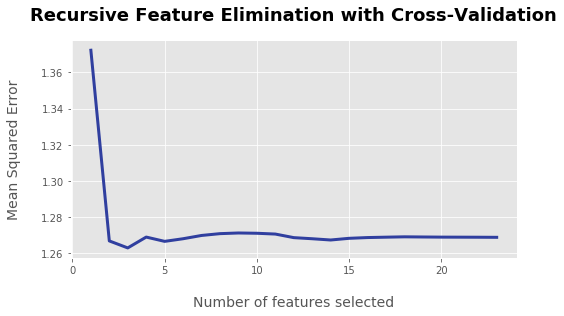

In [59]:
ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])

X = ema_target[att_features + calculated_features +["f_HmGameFut"]].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

rfmod = linear_model.BayesianRidge()

rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
rfecv.fit(X, y)
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(8, 4))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_*-1, color='#303F9F', linewidth=3)

plt.show()

In [60]:
print(pd.Series(rfecv.support_,index = X.columns)[lambda x: x==True])
#X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

f_Touches - Penalty Area    True
f_Chances Created           True
f_HmGameFut                 True
dtype: bool


#### Run the same again without Home Features

Optimal number of features: 2


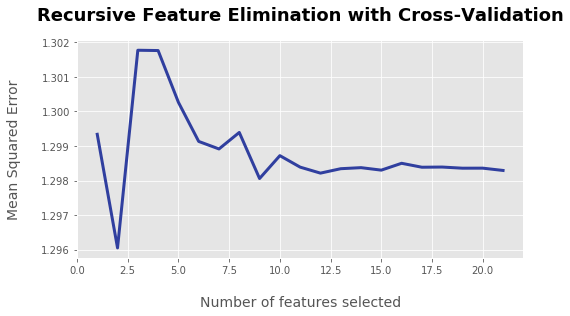

In [61]:
ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])

X = ema_target[att_features + calculated_features].copy()
X = X.drop("f_HmGame",axis=1)
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

rfmod = linear_model.BayesianRidge()

rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
rfecv.fit(X, y)
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(8, 4))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_*-1, color='#303F9F', linewidth=3)

plt.show()

In [62]:
print(pd.Series(rfecv.support_,index = X.columns)[lambda x: x==True])

f_Touches - Penalty Area    True
f_Goal Attempts             True
dtype: bool


### Variable Importance Scores
**Let's have a look at the Random Forest Regressor with 50 estimators to see which variables it deems important**

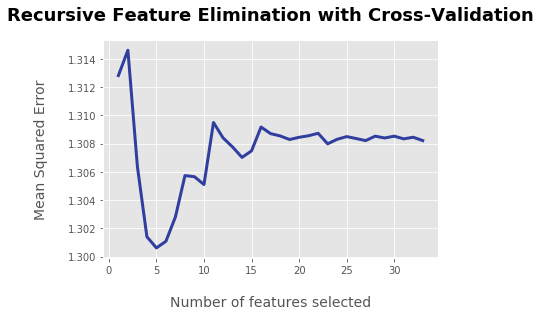

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [63]:
X = ema_target[features + calculated_features].copy()
X = X.drop("f_HmGame",axis=1)
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

rfmod = ensemble.RandomForestRegressor(n_estimators=50, random_state=42, max_depth = 2)
rfecv = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
rfecv.fit(X, y)

plt.figure(figsize=(6, 4))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_*-1, color='#303F9F', linewidth=3)

plt.show()
print(rfecv.estimator_)

In [64]:
print(pd.Series(rfecv.support_,index = X.columns)[lambda x: x==True])
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

f_Touches - Final Third        True
f_Touches - Penalty Area       True
f_Chances Created              True
f_Shots - Inside Box           True
f_Touches - Final Third log    True
dtype: bool


**------**<br>
Decision Trees and Random Forest Regressors have the ability to output **feature_importances_** to denote which features have the strongest impact on a model. For linear models we can output the **coef_** method, although this doesn't represent the importances in quite the same way. <br>
**----** 

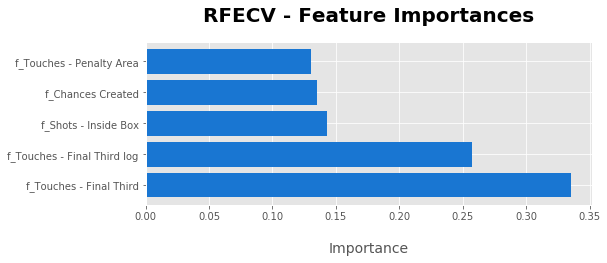

In [65]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(8, 3))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Variance Inflation Factor
This is another method to determine multi-colinearity in our data

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

The documentation suggests that any variables with a VIF of greater than 5 are highly correlated with other features.

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [67]:
## Running VIF on our attacking features plus a few others
X = ema_target[att_features + calculated_features +["f_HmGameFut"]].copy()
X = sm.add_constant(X)
round(pd.Series([variance_inflation_factor(X.values, i) 
            for i in range(X.shape[1])], 
              index=X.columns),5).sort_values(ascending=True)

C:\Users\Byron\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


f_HmGameFut                               1.35763
f_HmGame                                  1.38173
f_Goals From Penalties                    1.53353
f_Points                                  6.19387
f_Possession                              8.19674
f_Goals                                   9.05226
f_Big Chances Total                      14.44633
f_Shots - Inside Box                     15.63338
f_Touches - Penalty Area                 20.97004
f_ShotsRatio                             22.00120
f_ShOnTargetRatio                        32.65545
f_Chances Created                        40.93328
f_xA Expected Assists                    45.49800
f_US xG                                  48.60584
f_Passes - Final Third - Successful      70.28120
f_xG Open Play                           89.46227
f_xG Expected Goals                      93.73081
f_xGRatio                               112.89027
f_Touches - Final Third log             117.31643
f_netxg                                 119.87202


This confirms what we've already seen - many of our variables are correlated with each other.

Let's look at the VIF scores for the Random Forrest regressor restricted to just the "best" variables

In [68]:
X = ema_target[features + calculated_features].copy()
X = X.drop("f_HmGame",axis=1)
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X = sm.add_constant(X)
round(pd.Series([variance_inflation_factor(X.values, i) 
            for i in range(X.shape[1])], 
              index=X.columns),5).sort_values(ascending=True)

const                           1.00000
f_Chances Created               7.25165
f_Shots - Inside Box           11.26619
f_Touches - Penalty Area       15.62881
f_Touches - Final Third log    62.11277
f_Touches - Final Third        70.44615
dtype: float64

#### Summary
Even after reducing our variables the remaining variables still have a VIF higher than 5.

### Principal Component Analysis

Given that our variables our quite closely correlated, using Principal Component Analysis to reduce them may prove effective. If we're lucky, maybe we get two principal components reflecting Attacking and Defensive metrics.

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [69]:
model_features = features + calculated_features +["f_HmGameFut"] 
ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
#ema_target[model_features] = standard_scaler.fit_transform(ema_target[model_features])

# Separating out the features
X = ema_target.loc[:, model_features].values
# Separating out the target
#y = df.loc[:,['target']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.57289227 0.13268339 0.0580037 ]
0.7635793608974683


#### PCA observations
This doesn't look promising as using 3 principal components only explains about 76% of the variance in the dataset. Ideally we're looking for something as high as possible - Over 95% would be good.

In [71]:
ema_target_reset_index = ema_target.reset_index().drop("index",axis=1)
ema_pca = pd.concat([ema_target_reset_index,principalDf],axis=1).head(10)
ema_pca.head()

,matchid,f_Team,gameweek,season,f_HmGame,fixture,matchdate,gw_no,f_Goals,f_xG Conceded,f_Shots On Target,f_Touches - Penalty Area,f_Shots On Target Conceded,f_US xG Conceded,f_Touches - Final Third,f_xG Expected Goals,f_Points,f_xA Expected Assists,f_Passes - Final Third - Successful Conceded,f_Goals Conceded,f_Goal Attempts,f_Shots Conceded,f_Touches - Penalty Area Conceded,f_Passes - Final Third - Successful,f_Goals From Penalties,f_Shots - Inside Box,f_xG Open Play Conceded,f_Big Chances Conceded,f_Goal Attempts In Box Conceded,f_Possession,f_US xG,f_Chances Conceded,f_Big Chances Total,f_Touches - Final Third Conceded,f_xG Open Play,f_Chances Created,f_Touches - Final Third log,f_netxg,f_xGRatio,f_ShotsRatio,f_ShOnTargetRatio,f_HmGameFut,t_Goals,t_Goals Conceded,t_US xG,t_US xG Conceded,principal component 1,principal component 2,principal component 3
0,/matches/755324/,Manchester United,Gameweek 3,2014,0.486111,Burnley vs Manchester United,2014-08-30 12:45:00,3,1.000000,0.0,3.972222,16.916667,3.486111,0.477677,215.972222,0.0,0.513889,0.0,35.708333,1.486111,11.944444,8.083333,9.597222,113.097222,0.0,5.430556,0.0,0.000000,3.569444,57.744444,1.050831,7.569444,1.513889,98.777778,0.0,7.916667,5.375139,0.573154,0.687488,0.596394,0.332558,0,0,0,0.467281,0.513746,4.190939,-1.477590,5.770907
1,/matches/755324/,Burnley,Gameweek 3,2014,0.486111,Burnley vs Manchester United,2014-08-30 12:45:00,3,0.486111,0.0,1.486111,14.652778,3.513889,1.505202,151.472222,0.0,0.000000,0.0,84.263889,1.972222,10.541667,10.486111,15.805556,54.277778,0.0,6.027778,0.0,1.972222,6.486111,41.537500,0.613794,7.458333,0.513889,146.638889,0.0,7.000000,5.014043,-0.891408,0.289663,0.501321,0.140975,1,0,0,0.513746,0.467281,-4.652405,-0.900282,4.511187
2,/matches/755327/,Stoke City,Gameweek 3,2014,0.486111,Manchester City vs Stoke City,2014-08-30 15:00:00,3,0.513889,0.0,2.513889,22.138889,1.513889,0.889425,188.000000,0.0,0.513889,0.0,41.111111,1.000000,15.597222,8.027778,13.430556,82.638889,0.0,8.597222,0.0,1.000000,4.458333,61.294444,1.032733,5.000000,1.027778,129.458333,0.0,10.000000,5.217641,0.143309,0.537278,0.660200,0.161175,0,1,0,0.299792,0.891768,3.041996,-1.623018,6.610373
3,/matches/755327/,Manchester City,Gameweek 3,2014,0.513889,Manchester City vs Stoke City,2014-08-30 15:00:00,3,2.513889,0.0,4.486111,22.972222,1.541667,0.932851,175.041667,0.0,3.000000,0.0,83.958333,0.513889,10.944444,11.486111,23.513889,105.097222,0.0,7.458333,0.0,1.000000,7.972222,54.863889,1.394824,9.000000,3.000000,188.527778,0.0,8.944444,5.158759,0.461972,0.599235,0.487926,0.409898,1,0,1,0.891768,0.299792,3.592474,-1.049031,0.415558
4,/matches/755328/,Crystal Palace,Gameweek 3,2014,0.513889,Newcastle United vs Crystal Palace,2014-08-30 15:00:00,3,1.000000,0.0,3.027778,13.222222,7.027778,1.443860,110.027778,0.0,0.000000,0.0,94.513889,2.513889,6.569444,15.541667,24.027778,35.472222,0.0,3.055556,0.0,2.486111,8.055556,34.219444,0.394094,12.541667,0.513889,213.138889,0.0,5.569444,4.639955,-1.049766,0.214420,0.297111,0.460888,0,3,3,1.660560,1.697760,-9.077793,-0.065138,-1.349915


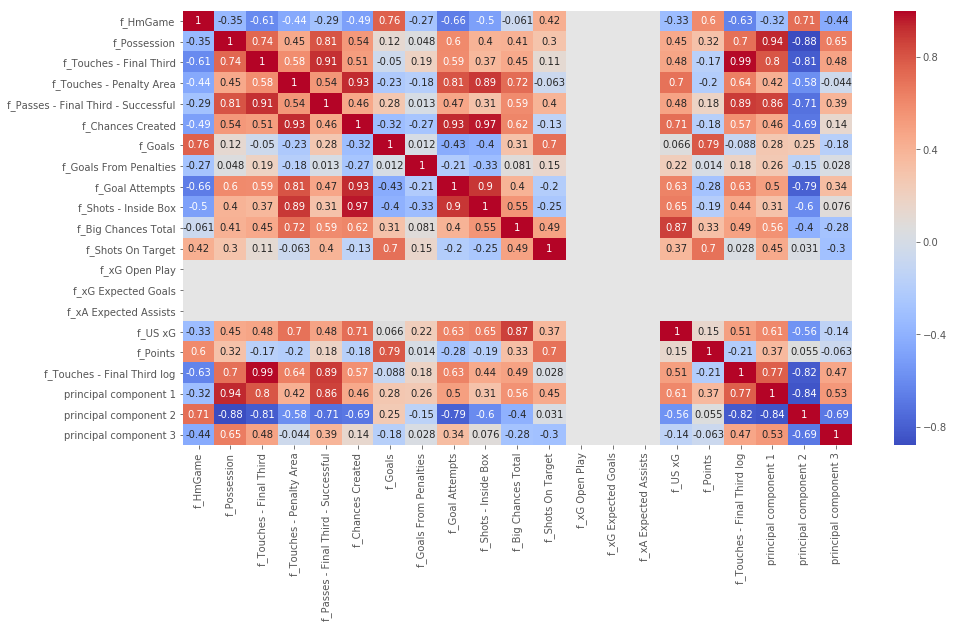

In [72]:
plt.figure(figsize=(15,8))

sns.heatmap(ema_pca[att_features + ["principal component 1","principal component 2","principal component 3"]].corr()
            ,cmap="coolwarm",annot =True)

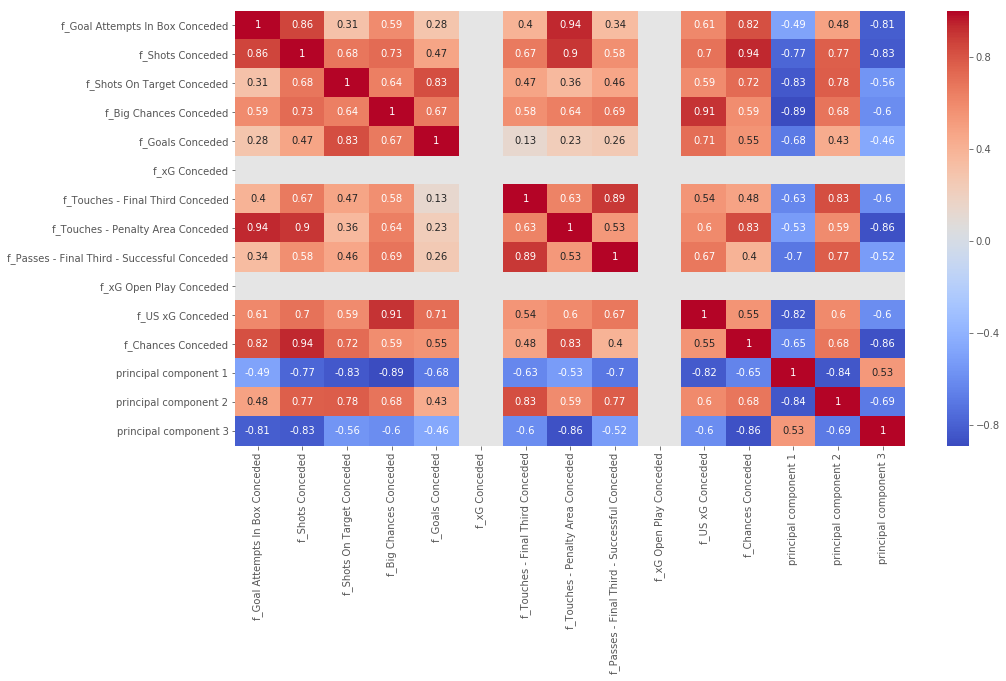

In [73]:
plt.figure(figsize=(15,8))

sns.heatmap(ema_pca[def_features + ["principal component 1","principal component 2","principal component 3"]].corr()
            ,cmap="coolwarm",annot =True)

# Tuning Hyperparameters

In [74]:
from sklearn.pipeline import Pipeline

In [75]:
ema_output = ema_no_reset(training, span=36,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target[features] = standard_scaler.fit_transform(ema_target[features])

X = ema_target[att_features + calculated_features +["f_HmGameFut"]].copy()
y = ema_target["t_Goals"].copy()
y = y.apply(lambda x: float(x))

# rfmod = lm.Lasso(alpha=0.5)

# rfe_lasso = RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
# rfe_lasso.fit(X, y)

# rfmod = lm.Ridge(alpha=0.5)
# rfe_ridge= RFECV(estimator=rfmod, step=1, cv=StratifiedKFold(n_splits=10, random_state=42), scoring='neg_mean_squared_error')
# rfe_ridge.fit(X, y)

In [76]:
kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

    
# rfe_lasso.get_params
# rfe_lasso.set_params(estimator=lm.Lasso(alpha=10,max_iter=10000))

In [77]:
np.logspace(-10, 10, 21)

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

### Comparing CV Scores with different Alpha values for Lasso and Ridge regression

In [78]:
print("Lasso CV Score with an Alpha of 0.5 :" + str(cross_val_score(lm.Lasso(alpha=0.5), X, y
                                                                , scoring='neg_mean_squared_error', cv=kfold).mean()))
print("Ridge CV Score with an Alpha of 0.5 :" + str(cross_val_score(lm.Ridge(alpha=0.5), X, y
                                                                , scoring='neg_mean_squared_error', cv=kfold).mean()))
lasso_scores = []
ridge_scores = []
for i in np.logspace(-10, 10, 21):
    ave_cv_score = cross_val_score(lm.Lasso(alpha=i, max_iter=10000), X, y, scoring='neg_mean_squared_error', cv=kfold).mean()
    lasso_scores.append(ave_cv_score*-1)
    
    ave_cv_score = cross_val_score(lm.Ridge(alpha=i, max_iter=10000), X, y, scoring='neg_mean_squared_error', cv=kfold).mean()
    ridge_scores.append(ave_cv_score*-1)
print("lowest cv score for lasso regression after cycling through multple alpha values: " + str(min(lasso_scores)))
print("lowest cv score for ridge regression after cycling through multple alpha values: " + str(min(ridge_scores)))

Lasso CV Score with an Alpha of 0.5 :-1.419884438907926
Ridge CV Score with an Alpha of 0.5 :-1.2698153111113537
lowest cv score for lasso regression after cycling through multple alpha values: 1.2643638996438233
lowest cv score for ridge regression after cycling through multple alpha values: 1.2651032831453446


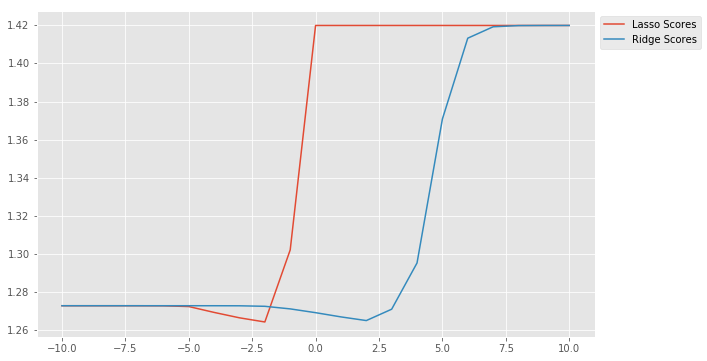

1.2643638996438233
1.2651032831453446


In [79]:
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(-10,10,21), lasso_scores,label="Lasso Scores")
plt.plot(np.linspace(-10,10,21), ridge_scores, label ="Ridge Scores")
plt.legend(bbox_to_anchor=[1,1])
plt.show()

print(min(lasso_scores))
print(min(ridge_scores))

### Plotting a validation curve

In [80]:
from sklearn.model_selection import validation_curve

[1.3277825  1.3277825  1.3277825  1.32778249 1.32778244 1.32778186
 1.32777613 1.32771951 1.327208   1.32387156 1.30660827 1.28227323
 1.27400338 1.27502596 1.299595   1.37432342 1.41515588 1.42089203
 1.42148822 1.42154808 1.42155406]


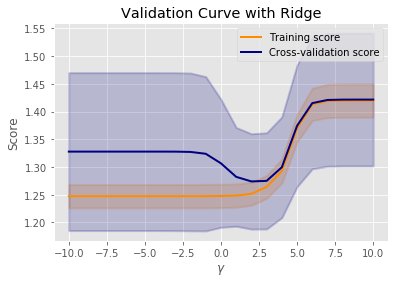

In [81]:
param_range = np.linspace(-10, 10, 21)
train_scores, test_scores = validation_curve(lm.Ridge(), X, y, "alpha",np.logspace(-10, 10, 21)
                                             ,cv=5,scoring = "neg_mean_squared_error")


train_scores_mean = np.mean(train_scores*-1, axis=1)
train_scores_std = np.std(train_scores*-1, axis=1)
test_scores_mean = np.mean(test_scores*-1, axis=1)
test_scores_std = np.std(test_scores*-1, axis=1)
print(test_scores_mean)


plt.title("Validation Curve with Ridge")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
[1.24744922 1.24744922 1.24744922 1.24744922 1.24744922 1.24744922
 1.24744922 1.24744925 1.24745132 1.24750014 1.24777334 1.24851289
 1.25172636 1.26410708 1.29280553 1.36990109 1.41294791 1.41903804
 1.41967158 1.41973519 1.41974155]


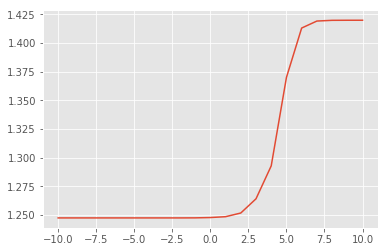

In [82]:
print(param_range)
print(train_scores_mean)
plt.plot(param_range, np.array(train_scores_mean))
plt.show()

### Comparing Number of Estimators for a Random Forrest Regressor

In [83]:
cv_scores = []
for i in [2,5,10,20,40,50,70,100]:
    ave_cv_score = cross_val_score(ensemble.RandomForestRegressor(n_estimators=i, random_state=42, max_depth = 2)
                                   , X, y, scoring='neg_mean_squared_error', cv=kfold).mean()
    cv_scores.append(ave_cv_score*-1)

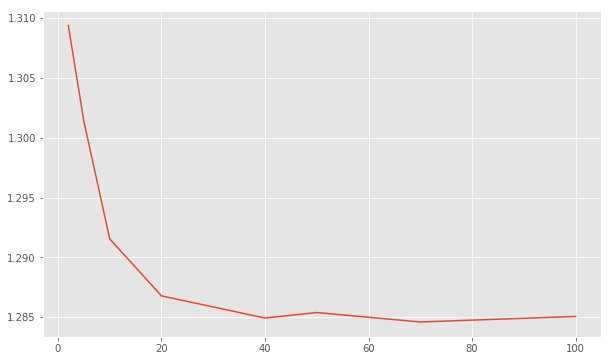

1.2846126867179848


In [84]:
plt.figure(figsize=(10, 6))
plt.plot([2,5,10,20,40,50,70,100], cv_scores,label="Random Forrest Scores")
plt.show()
print(min(cv_scores))

### Using GridSearchCV

In [85]:
gslmGF = ms.GridSearchCV(estimator=lm.Lasso(max_iter=10000),
                     param_grid={'alpha': np.logspace(-10, 10, 21)},
                     scoring='neg_mean_squared_error',
                     cv=kfold)

In [86]:
lm.Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [87]:
gslmGF.fit(X,y)
print(gslmGF.best_estimator_)
print(gslmGF.best_score_)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-1.2644669549853278


# Comparing our predicitions across teams

We will use our model to predict Goals Scored and append the predicted value on to our base dataset.<br>
Let's also just check the mean squared error we get to make sure it makes sense.

In [89]:
pred_g = gslmGF.predict(X)
ema_output = ema_no_reset(training, span=span,feature_cols=features)
ema_target = pd.merge(ema_output, target_goals, on = ['f_Team','matchid']).dropna()
ema_target = ema_target[ema_target["t_Goals"]<6]
ema_target["Pred_GF"] = pred_g

print(metrics.mean_squared_error(y, pred_g))


1.25458494434403


In [90]:
ema_target.tail()

,matchid,f_Team,gameweek,season,f_HmGame,fixture,matchdate,gw_no,f_Goals,f_xG Conceded,f_Shots On Target,f_Touches - Penalty Area,f_Shots On Target Conceded,f_US xG Conceded,f_Touches - Final Third,f_xG Expected Goals,f_Points,f_xA Expected Assists,f_Passes - Final Third - Successful Conceded,f_Goals Conceded,f_Goal Attempts,f_Shots Conceded,f_Touches - Penalty Area Conceded,f_Passes - Final Third - Successful,f_Goals From Penalties,f_Shots - Inside Box,f_xG Open Play Conceded,f_Big Chances Conceded,f_Goal Attempts In Box Conceded,f_Possession,f_US xG,f_Chances Conceded,f_Big Chances Total,f_Touches - Final Third Conceded,f_xG Open Play,f_Chances Created,f_Touches - Final Third log,f_netxg,f_xGRatio,f_ShotsRatio,f_ShOnTargetRatio,f_HmGameFut,t_Goals,t_Goals Conceded,t_US xG,t_US xG Conceded,Pred_GF
3035,/matches/919270/,Swansea City,Gameweek 38,2017,0.482327,Swansea City vs Stoke City,2018-05-13 15:00:00,38,0.791751,1.415453,2.653909,15.033310,4.961984,1.657671,138.243816,0.683473,0.930142,0.444130,100.417545,1.510087,8.775636,14.044365,25.782363,57.586553,0.040513,4.938543,1.057176,2.197103,8.787682,44.439185,0.773638,10.388319,1.054085,198.024649,0.430972,6.175972,4.827402,-0.884033,0.318198,0.384559,0.302418,1,1,2,1.70936,1.75436,1.033379
3036,/matches/919271/,Leicester City,Gameweek 38,2017,0.534959,Tottenham Hotspur vs Leicester City,2018-05-13 15:00:00,38,1.347835,1.110179,3.864700,19.428963,4.267057,1.284039,156.526187,1.172412,1.243329,0.774320,75.581615,1.552550,11.589145,12.125756,21.428524,62.042278,0.135075,7.009267,0.832372,1.868652,7.462292,49.406753,1.327129,8.936687,1.738200,171.596257,0.740797,8.204823,5.013032,0.043089,0.508251,0.488686,0.333476,0,4,5,1.27359,1.83248,1.071122
3037,/matches/919271/,Tottenham Hotspur,Gameweek 38,2017,0.479157,Tottenham Hotspur vs Leicester City,2018-05-13 15:00:00,38,1.894080,0.882695,5.737966,27.039657,3.258432,1.027392,222.037921,1.446975,2.086270,0.986310,43.903363,0.833227,15.837548,9.624413,16.298303,109.024287,0.070124,9.163770,0.561477,1.267822,6.133891,62.387800,1.766953,6.616518,2.610015,118.428030,1.111689,11.791133,5.369292,0.739561,0.632332,0.622008,0.362301,1,5,4,1.83248,1.27359,2.026815
3038,/matches/919272/,Everton,Gameweek 38,2017,0.524917,West Ham United vs Everton,2018-05-13 15:00:00,38,1.237227,1.181299,3.257155,17.405572,4.428843,1.365926,149.120644,0.938919,1.444561,0.560300,85.174723,1.290645,9.720112,13.632999,22.964485,61.321681,0.086142,6.326100,0.806201,1.695581,7.592118,46.774033,1.175747,9.894762,1.721198,184.922434,0.620882,7.210181,4.968292,-0.190179,0.462588,0.416223,0.335094,0,1,3,1.67867,1.18299,0.912567
3039,/matches/919272/,West Ham United,Gameweek 38,2017,0.513681,West Ham United vs Everton,2018-05-13 15:00:00,38,1.252231,1.274405,3.424557,17.344361,4.959072,1.494630,139.267733,0.805306,1.132596,0.519676,98.840847,1.736217,9.988906,14.761580,24.473506,54.338493,0.053635,6.117113,0.950130,1.673820,8.480104,43.671909,0.974728,11.389585,1.392187,198.773326,0.554460,7.361811,4.886738,-0.519902,0.394729,0.403584,0.342836,1,3,1,1.18299,1.67867,1.175299


Let's use the 2017 season to understand our predictions a bit better

In [91]:
ema_2017 = ema_target[ema_target["season"]==2017]
ema_2017 = ema_target[ema_target["season"]==2017]
ema_2017.loc[:,"gw_no"] = ema_2017["gameweek"].str[9:].astype(int)

alph_order=sorted(ema_2017["f_Team"].unique())

C:\Users\Byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


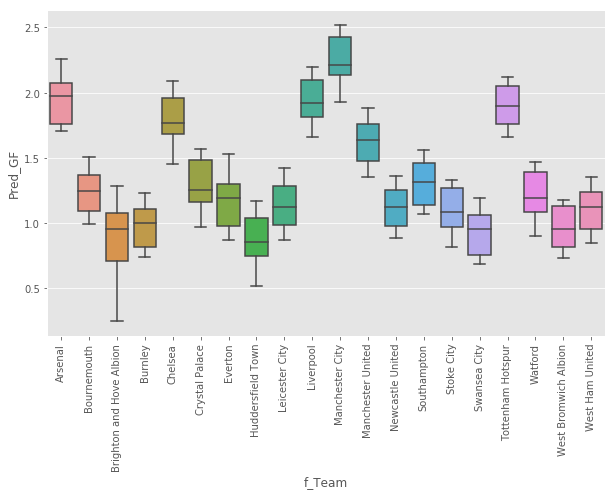

In [92]:
plt.figure(figsize =(10,6))
sns.boxplot(x="f_Team", y = "Pred_GF", data = ema_2017,order = alph_order)
plt.xticks(rotation=90)
plt.show()

#### Summary
Our predicted Goals value seems to be quite good at separating out the better teams, although there's not a huge amount of differentiation in some of the weaker teams - which is generally a problem in football predictions.

#### Plotting one team over the season

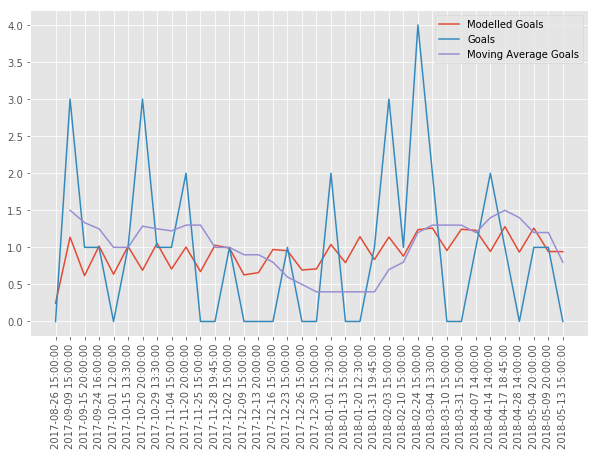

In [93]:
plot_df=ema_2017[ema_2017["f_Team"]=="Brighton and Hove Albion"]
att_strength = np.array(plot_df["Pred_GF"])
goals = np.array(plot_df["t_Goals"])
moving_averge_goals = plot_df["t_Goals"].transform(lambda row: row.rolling(window=10, min_periods=2).mean())
gws = plot_df["gw_no"].unique()
dates = plot_df["matchdate"].unique()
#plot_df.groupby("gw_no")["Pred_GF"].sum()
#plot_df.head()
plt.figure(figsize=(10, 6))

plt.plot(dates, att_strength, label="Modelled Goals")
plt.plot(dates, goals, label="Goals")
plt.plot(dates, moving_averge_goals, label="Moving Average Goals")
plt.legend(bbox_to_anchor=[1,1])
plt.xticks(rotation=90)
plt.show()

#### Prediction Correlation

In [94]:
ema_target[["t_Goals","f_HmGameFut"] + att_features+calculated_features+["Pred_GF"]].corr()["t_Goals"].sort_values(ascending =False)

t_Goals                                1.000000
Pred_GF                                0.341578
f_Touches - Penalty Area               0.293291
f_Chances Created                      0.287008
f_Touches - Final Third                0.285307
f_Goal Attempts                        0.284596
f_Touches - Final Third log            0.284079
f_US xG                                0.281567
f_Shots On Target                      0.281054
f_Shots - Inside Box                   0.279898
f_ShotsRatio                           0.277563
f_Passes - Final Third - Successful    0.275665
f_xGRatio                              0.271211
f_netxg                                0.271138
f_Big Chances Total                    0.259728
f_Possession                           0.255034
f_Goals                                0.252596
f_Points                               0.230876
f_ShOnTargetRatio                      0.153976
f_HmGameFut                            0.148222
f_Goals From Penalties                 0

#### Summary
Our predicted Goals Value does have a higher correlation with actual goals, but only slightly!

In [95]:
ema_2017 = ema_target[ema_target["season"]==2017]
ema_2017["gameweek"].str[9:].astype(int)

2280     1
2281     1
2282     1
2283     1
2284     1
        ..
3035    38
3036    38
3037    38
3038    38
3039    38
Name: gameweek, Length: 754, dtype: int32